In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, vstack, csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(7, 7)})

### Helper functions

In [3]:
def get_summary(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [4]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Percentage of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A = (((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0, 1, 2, 3, 4, 5, 6]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in recall matrix",A.sum(axis=1))

In [7]:
!ls

EDA.ipynb                 README.md                 assignment_data_train.csv
Modelling.ipynb           assignment_data_test.csv  assignment_details.pdf


In [5]:
train = pd.read_csv('./assignment_data_train.csv')

In [6]:
train.head()

,EVENT_TYPE,comment,EVENT_ID
0,PROMISE_TO_PAY,PROMISE TO PAY BY CASH ON 21 NOV 2018,9346
1,RINGING,RNG.,10430
2,NOT_CONTACTABLE,ASSIGNED TO AGENCY AG ENTERPRISES,21762
3,PAID,PAID,19014
4,PROMISE_TO_PAY,PTP GIVEN BY CUSTOMER TO AGENCY,10400


### Converting the class labels

In [7]:
le = LabelEncoder()
y = le.fit_transform(train.EVENT_TYPE)

In [8]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6])

In [9]:
train['event'] = y

In [10]:
train.head()

,EVENT_TYPE,comment,EVENT_ID,event
0,PROMISE_TO_PAY,PROMISE TO PAY BY CASH ON 21 NOV 2018,9346,5
1,RINGING,RNG.,10430,6
2,NOT_CONTACTABLE,ASSIGNED TO AGENCY AG ENTERPRISES,21762,2
3,PAID,PAID,19014,4
4,PROMISE_TO_PAY,PTP GIVEN BY CUSTOMER TO AGENCY,10400,5


In [11]:
X = train[['comment']]
y = train.event

### Stratified train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42, test_size=0.2)

In [13]:
X_train.shape

(11229, 1)

In [14]:
X_test.shape

(2808, 1)

In [15]:
Counter(y_train)

Counter({0: 1112, 5: 2233, 6: 3001, 1: 626, 2: 1450, 4: 2696, 3: 111})

In [16]:
Counter(y_test)

Counter({5: 558, 0: 278, 1: 156, 4: 674, 6: 751, 2: 363, 3: 28})

## Text Preprocessing

#### Removing the numbers & punctuations from the text

In [17]:
from nltk.tokenize import RegexpTokenizer

In [18]:
tokenizer = RegexpTokenizer(r'\w+')

In [19]:
def clean_text(text):
    text = text.lower()
    sent = []
    for each in tokenizer.tokenize(text):
        if not each.isdigit():
            sent.append(each)
    return ' '.join(sent)

In [20]:
clean_text('CM HAS MADE THE PYMT OF RS 3173 THROUGH AGENCY...')

'cm has made the pymt of rs through agency'

In [21]:
X_train['comment_cleaned'] = X_train.comment.apply(clean_text)

/Users/mayukhsarkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
X_train.head()

,comment,comment_cleaned
12669,ASSIGNED TO AGENCY AG ENTERPRISES,assigned to agency ag enterprises
6956,REASSIGNED BY HARDIK KADAKIA,reassigned by hardik kadakia
3176,RINGING.,ringing
6030,RINGING.,ringing
8922,RNG.,rng


In [23]:
X_test['comment_cleaned'] = X_test.comment.apply(clean_text)

/Users/mayukhsarkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Featurize the text data

In [24]:
cunt_3grams = CountVectorizer(ngram_range=(1, 3))

In [25]:
cunt_3grams.fit(X_train.comment_cleaned)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [26]:
dtrain = cunt_3grams.transform(X_train.comment_cleaned)
dtest = cunt_3grams.transform(X_test.comment_cleaned)

In [27]:
dtrain.get_shape()

(11229, 10339)

In [28]:
dtest.get_shape()

(2808, 10339)

- The feaurized data is of very high dimensional in nature.
- Because it is of very high dimensional, we would mostly use GLM or Generalised Linear Models
- We can try some tree based model but with SUBSTANTIAL amount feature selection
- Lastly we can use LSTM to model the sequence with a softmax output layer but the performace may not be good as the training data is very less.
- The dataset is very small and hence we can't create our own word2vec or GLoVE models
- We may try to use `TfidfVectorizer` along with `CountVectorizer` to decrese the loss but all at the cost of losing model iterpretibilty

## Generalized Linear Models - Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [81]:
params = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}

In [106]:
estimator = LogisticRegression(random_state=42, solver='lbfgs', 
                               multi_class='multinomial', max_iter=300)

In [107]:
print(estimator)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


In [108]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'neg_log_loss', 'accuracy'},
                    refit='neg_log_loss', # Because we are using multiple scoring metrics
                    cv=StratifiedKFold(4, shuffle=True), # Because some class labels are imbalanced
                    return_train_score=True,
                    verbose=2)

In [ ]:
grid.fit(dtrain, y_train)

In [131]:
g = get_summary(grid)
g.sort_values(by='test_neg_log_loss', ascending=False)

,Iter #,train_neg_log_loss,test_neg_log_loss,train_accuracy,test_accuracy,fit_time,score_time,C
4,5,-0.226311,-0.318759,0.924274,0.895182,1.555254,0.003945,1.0000
5,6,-0.202909,-0.339287,0.926025,0.894381,3.305328,0.003562,10.0000
3,4,-0.313367,-0.359338,0.908392,0.891353,0.661060,0.003233,0.1000
6,7,-0.198213,-0.394134,0.926025,0.892154,3.341432,0.003962,100.0000
7,8,-0.197523,-0.508462,0.926025,0.892154,3.412027,0.004119,1000.0000
2,3,-0.556635,-0.571138,0.877965,0.871672,0.356486,0.003632,0.0100
8,9,-0.197431,-0.598493,0.926025,0.890106,3.811273,0.004088,10000.0000
1,2,-1.124199,-1.127907,0.717665,0.713599,0.312855,0.005048,0.0010
0,1,-1.588451,-1.589066,0.416333,0.414819,0.433398,0.003659,0.0001


### Check Overfitting

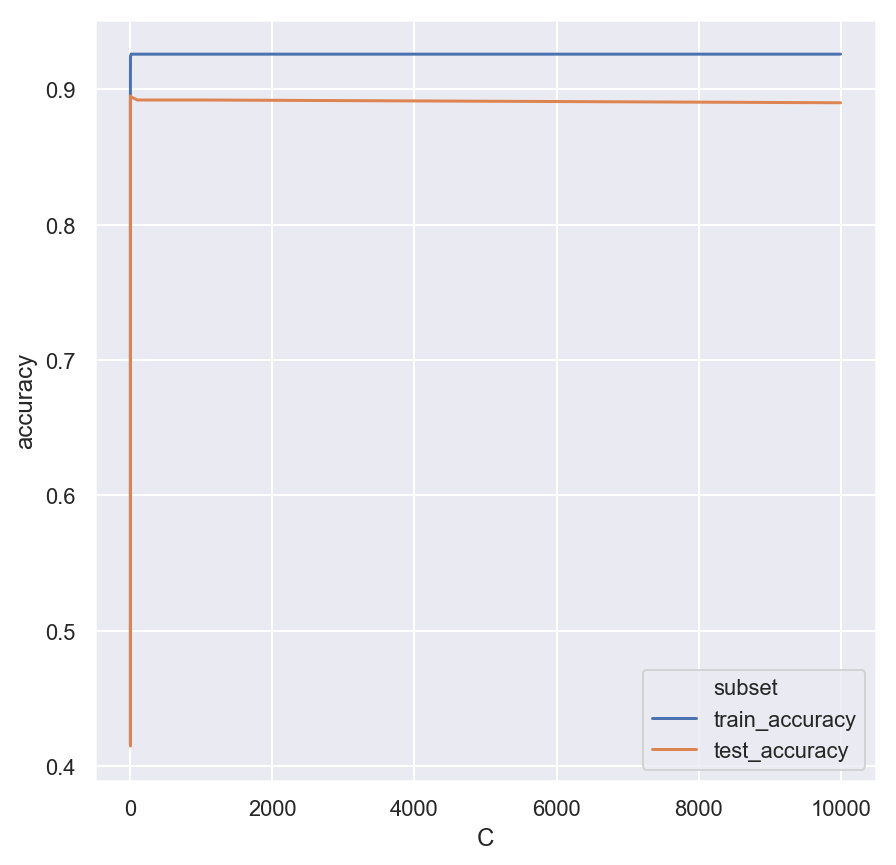

In [127]:
plot_scores = g[['C', 'train_accuracy', 'test_accuracy']]
df = pd.melt(plot_scores, id_vars='C', var_name='subset', value_name='accuracy')
sns.lineplot(x='C', y='accuracy', hue='subset', data=df);

In [113]:
grid.best_params_

{'C': 1.0}

In [128]:
best_model = grid.best_estimator_

### Performace on test data (Not actual test)

In [132]:
from sklearn.metrics import log_loss

In [134]:
pred_y = best_model.predict_proba(dtest)

In [135]:
log_loss(y_test, pred_y)

0.3153404466580785

In [140]:
pred_y_raw = best_model.predict(dtest)

Percentage of misclassified points  10.683760683760683
-------------------------------------------------- Confusion matrix --------------------------------------------------


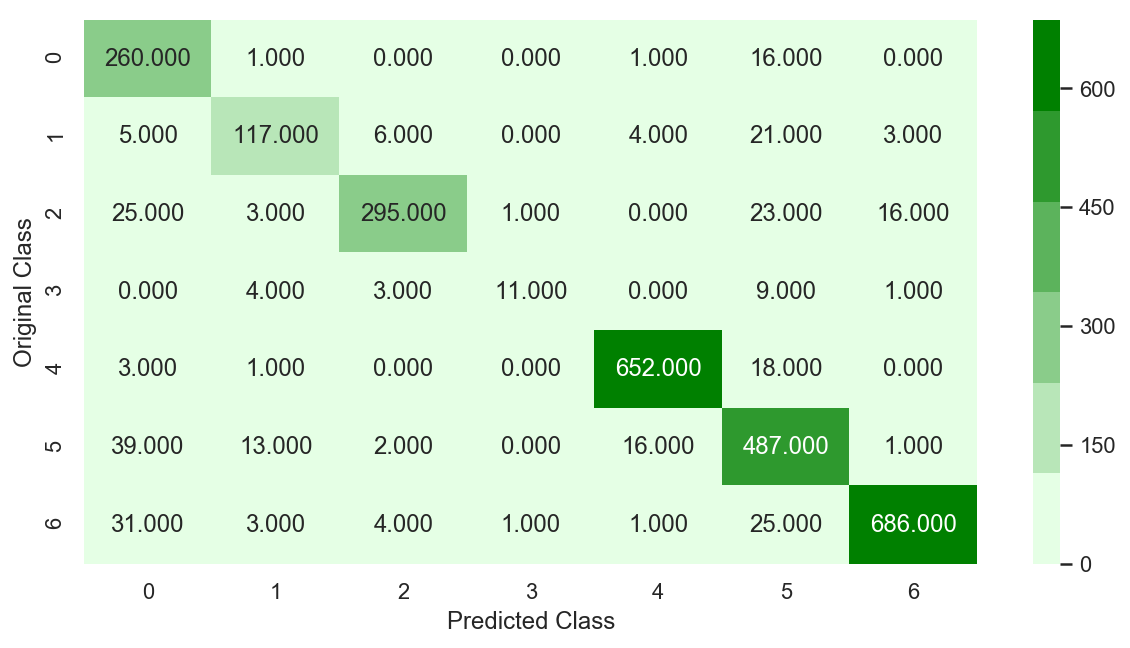

-------------------------------------------------- Precision matrix --------------------------------------------------


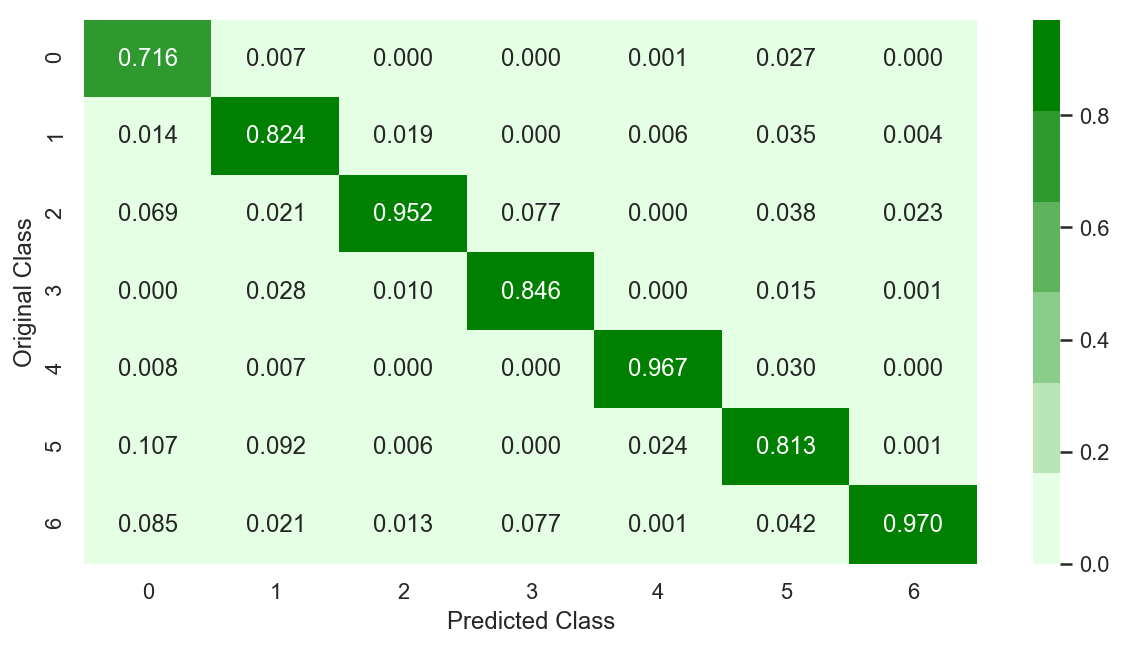

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


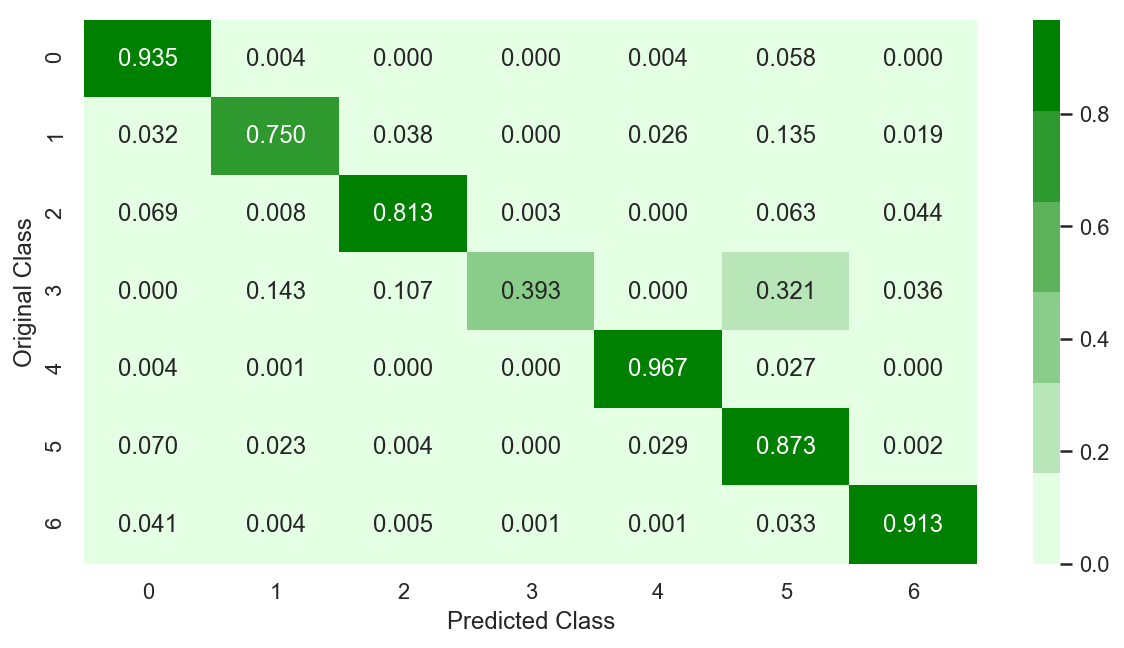

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1.]


In [147]:
plot_confusion_matrix(y_test, pred_y_raw)

### Observations

- As expected, the performace of a simple linear model is very good as the text data is of very high dimensional
- We can see performance of class 3 is not acceptable though as it was shown in recall matrix. There seems to some confusion betweem class 3 and class 5.
- Because we are using multiclass log-loss instead of accuracy, even a small deviation penalises the Precision and Recall matrix extensively.
- If we dig deeper in **Recall Matrix**, we see that class 3 is `NOT_WILLING_TO_PAY` and class 5 is `PROMISE_TO_PAY` has some confusion within. As it was already mentioned in the EDA section that because of class imbalance of class 3, this can create probelms in future.
- My next target is improve the performace on class label 3 so that the accuracy goes above 90%

### Improving performance on class 3 (`NOT_WILLING_TO_PAY`)

#### Observations

- Presense of the phrase `NOT READY TO PAY` would be a strong indicator
- EDA revealed the name `HARDIK KADAKIA` is strongly associated
- The word `CHEATED` is also frequently used which makes sense too.

#### Feature Engineering

In [ ]:
X_train['isNRTP'] = X_train.comment_cleaned.apply(lambda x: 'not redy to pay' in x or 'not ready to pay' in x)
X_test['isNRTP'] = X_test.comment_cleaned.apply(lambda x: 'not redy to pay' in x or 'not ready to pay' in x)

In [174]:
train.iloc[X_train[X_train.isNRTP == True].index].EVENT_TYPE.value_counts()

NOT_WILLING_TO_PAY    14
PROMISE_TO_PAY         2
CASH_PICK_UP           1
NOT_CONTACTABLE        1
FOLLOW_UP              1
Name: EVENT_TYPE, dtype: int64

In [ ]:
X_train['isHK'] = X_train.comment_cleaned.apply(lambda x: 'hardik kadakia' in x)
X_test['isHK'] = X_test.comment_cleaned.apply(lambda x: 'hardik kadakia' in x)

In [179]:
train.iloc[X_train[X_train.isHK == True].index].EVENT_TYPE.value_counts()

PROMISE_TO_PAY        118
RINGING                97
NOT_CONTACTABLE        60
FOLLOW_UP              45
NOT_WILLING_TO_PAY     35
PAID                   32
CASH_PICK_UP           18
Name: EVENT_TYPE, dtype: int64

In [ ]:
X_train['cheated'] = X_train.comment_cleaned.apply(lambda x: 'cheated' in x)
X_test['cheated'] = X_test.comment_cleaned.apply(lambda x: 'cheated' in x)

In [181]:
train.iloc[X_train[X_train.cheated == True].index].EVENT_TYPE.value_counts()

NOT_WILLING_TO_PAY    3
PROMISE_TO_PAY        1
NOT_CONTACTABLE       1
FOLLOW_UP             1
Name: EVENT_TYPE, dtype: int64

In [ ]:
ef = X_train[['isNRTP', 'isHK', 'cheated']]
ef['isNRTP'] = ef.isNRTP.astype(int)
ef['isHK'] = ef.isHK.astype(int)
ef['cheated'] = ef.cheated.astype(int)
ef_sparse_train = csr_matrix(ef.values)

In [205]:
ef_sparse_train.get_shape()

(11229, 3)

In [209]:
dtrain.get_shape()

(11229, 10339)

In [ ]:
ef = X_test[['isNRTP', 'isHK', 'cheated']]
ef['isNRTP'] = ef.isNRTP.astype(int)
ef['isHK'] = ef.isHK.astype(int)
ef['cheated'] = ef.cheated.astype(int)
ef_sparse_test = csr_matrix(ef.values)

In [208]:
ef_sparse_test.get_shape()

(2808, 3)

In [210]:
dtest.get_shape()

(2808, 10339)

In [214]:
dtrain_new = hstack((dtrain, ef_sparse_train))

In [215]:
dtrain_new.get_shape()

(11229, 10342)

In [216]:
dtest_new = hstack((dtest, ef_sparse_test))

In [217]:
dtest_new.get_shape()

(2808, 10342)

#### Modelling

In [218]:
params = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}

In [219]:
estimator = LogisticRegression(random_state=42, solver='lbfgs', 
                               multi_class='multinomial', max_iter=300)

In [221]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'neg_log_loss', 'accuracy'},
                    refit='neg_log_loss', # Because we are using multiple scoring metrics
                    cv=StratifiedKFold(4, shuffle=True), # Because some class labels are imbalanced
                    return_train_score=True,
                    verbose=2)

In [ ]:
grid.fit(dtrain_new, y_train)

In [237]:
g = get_summary(grid)
g.sort_values(by='test_neg_log_loss', ascending=False)

,Iter #,train_neg_log_loss,test_neg_log_loss,train_accuracy,test_accuracy,fit_time,score_time,C
4,5,-0.226406,-0.316683,0.923858,0.895895,1.734163,0.004417,1.0000
5,6,-0.203073,-0.333170,0.925669,0.896963,3.516907,0.004183,10.0000
3,4,-0.313327,-0.359383,0.908392,0.891620,0.694856,0.006965,0.1000
6,7,-0.198372,-0.382293,0.925609,0.895004,3.302027,0.004049,100.0000
7,8,-0.197671,-0.511554,0.925609,0.892778,4.205616,0.004073,1000.0000
2,3,-0.556326,-0.571467,0.877549,0.872206,0.382133,0.005507,0.0100
8,9,-0.197617,-0.574214,0.925609,0.892510,3.650975,0.004245,10000.0000
1,2,-1.123991,-1.127868,0.715051,0.712619,0.359984,0.004102,0.0010
0,1,-1.588398,-1.589058,0.418410,0.417223,0.429746,0.005586,0.0001


In [238]:
best_model = grid.best_estimator_

In [239]:
pred_y_raw = best_model.predict(dtest_new)

Percentage of misclassified points  10.683760683760683
-------------------------------------------------- Confusion matrix --------------------------------------------------


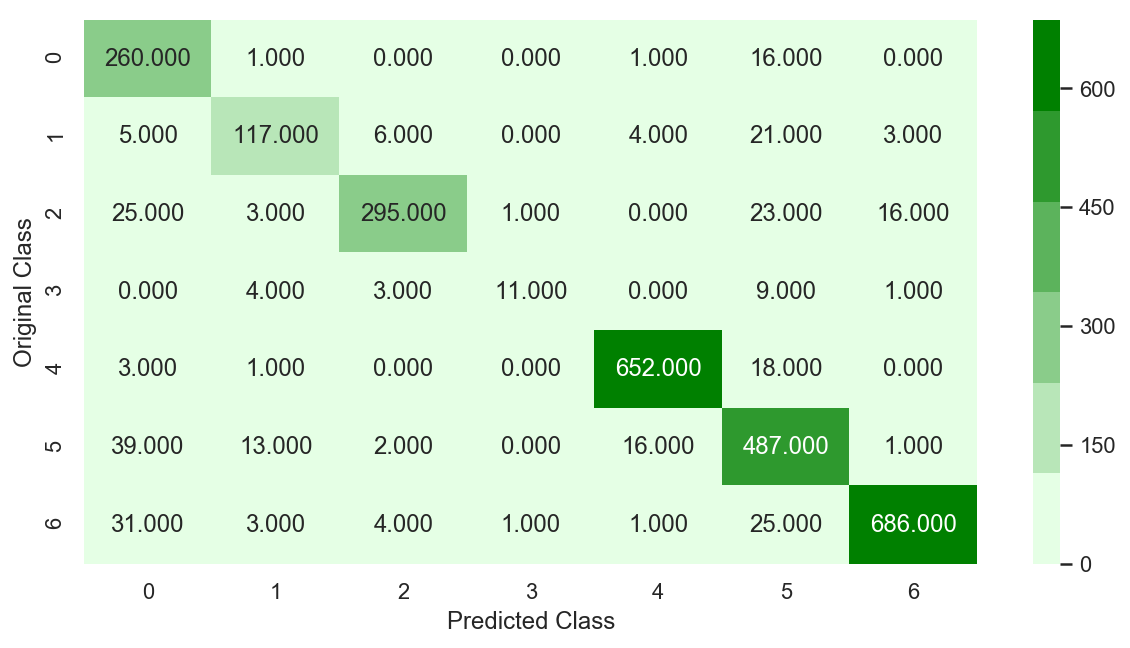

-------------------------------------------------- Precision matrix --------------------------------------------------


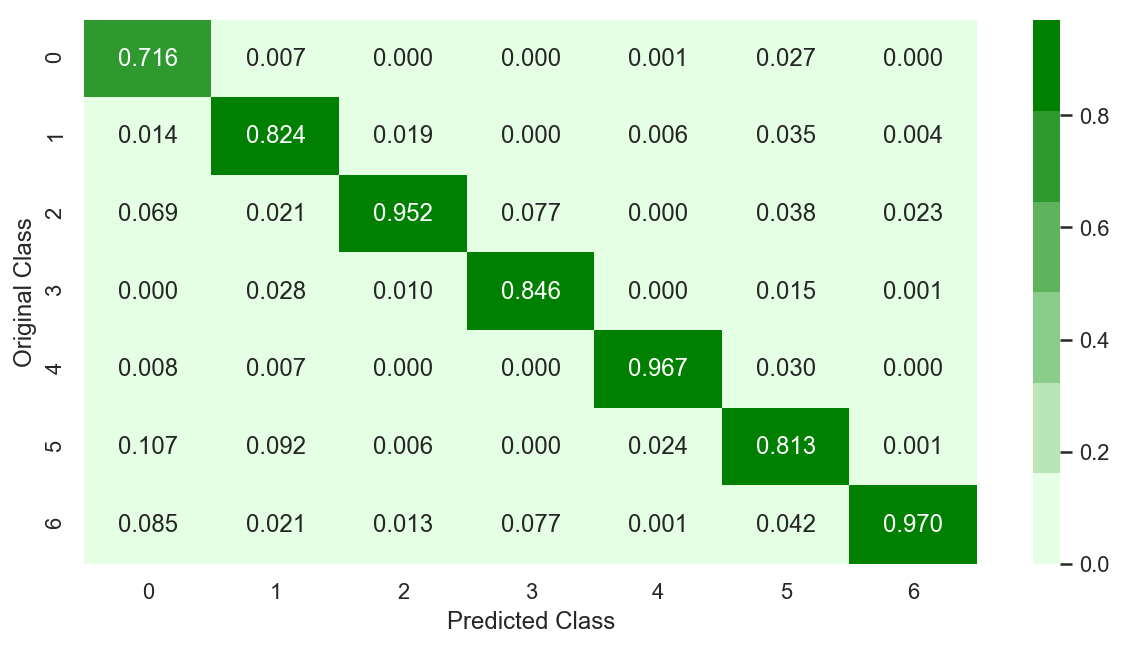

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


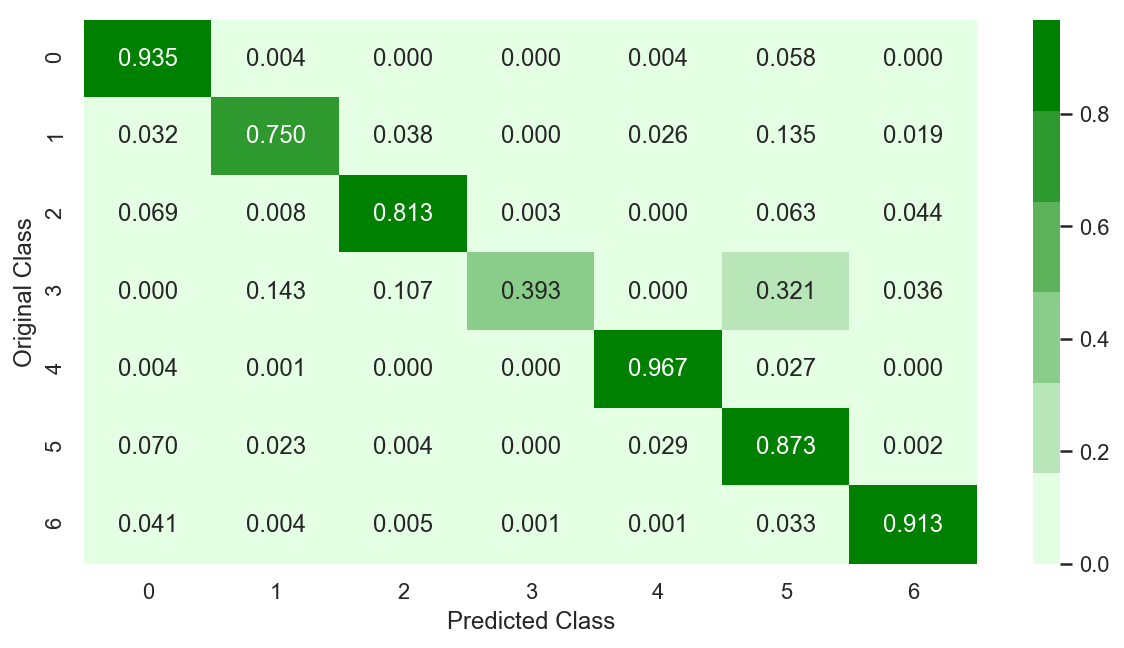

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1.]


In [240]:
plot_confusion_matrix(y_test, pred_y_raw)

- Manual feauture engineering to improve the logloss didn't work much

### Using unigram TFIDF along with CountVectorizer 3 gram

In [30]:
tfidf = TfidfVectorizer(ngram_range=(1, 1))
tfidf.fit(X_train.comment_cleaned)
tfidf_train = tfidf.transform(X_train.comment_cleaned)
tfidf_test = tfidf.transform(X_test.comment_cleaned)

In [31]:
tfidf_train.get_shape()

(11229, 1169)

In [32]:
tfidf_test.get_shape()

(2808, 1169)

In [231]:
dtrain_new.get_shape()

(11229, 10342)

In [232]:
dtrain_tfidf = hstack((dtrain_new, tfidf_train))
dtest_tfidf = hstack((dtest_new, tfidf_test))

In [233]:
dtrain_tfidf.get_shape()

(11229, 11511)

In [234]:
dtest_tfidf.get_shape()

(2808, 11511)

In [244]:
from sklearn.preprocessing import StandardScaler

In [248]:
sclr = StandardScaler(with_mean=False)
sclr.fit(dtrain_tfidf)
dtrain_tfidf_sclr = sclr.transform(dtrain_tfidf)
dtest_tfidf_sclr = sclr.transform(dtest_tfidf)

In [249]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'neg_log_loss', 'accuracy'},
                    refit='neg_log_loss', # Because we are using multiple scoring metrics
                    cv=StratifiedKFold(4, shuffle=True), # Because some class labels are imbalanced
                    return_train_score=True,
                    verbose=2)

In [ ]:
grid.fit(dtrain_tfidf_sclr, y_train)

In [251]:
g = get_summary(grid)
g.sort_values(by='test_neg_log_loss', ascending=False)

,Iter #,train_neg_log_loss,test_neg_log_loss,train_accuracy,test_accuracy,fit_time,score_time,C
2,3,-0.211751,-0.342936,0.925164,0.891086,3.840858,0.007657,0.0100
3,4,-0.200233,-0.357755,0.925520,0.891531,3.577245,0.004192,0.1000
1,2,-0.279195,-0.394564,0.921958,0.888592,2.139276,0.004098,0.0010
4,5,-0.198100,-0.394783,0.925579,0.891709,3.757115,0.005146,1.0000
5,6,-0.197606,-0.556477,0.925669,0.886366,4.443913,0.004588,10.0000
6,7,-0.197517,-0.712278,0.925669,0.886633,3.798798,0.004418,100.0000
0,1,-0.608196,-0.717216,0.907442,0.868911,1.289212,0.004297,0.0001
7,8,-0.197448,-0.845226,0.925728,0.883427,4.314415,0.006742,1000.0000
8,9,-0.197405,-0.894836,0.925758,0.883338,5.049834,0.007675,10000.0000


## Non Linear Tree based models with feature selection

In [33]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [35]:
sel = SelectFromModel(ExtraTreesClassifier(n_estimators = 1000, n_jobs=-1, verbose=1))
sel.fit(dtrain, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   37.0s finished


SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [36]:
dtrain_new_min = sel.transform(dtrain)
dtest_new_min = sel.transform(dtest)

In [37]:
dtrain_new_min.shape

(11229, 574)

In [38]:
import lightgbm as lgb

/Users/mayukhsarkar/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [39]:
params = {
    'max_depth': [2, 4, 6],  # Typically small value for low variance 
    'subsample': [0.5, 0.75, 1.0], # Row sampling like Random Forest 
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],  # Column sampling like Random Forest
    'num_leaves': [2**2, 2**4, 2**6]  # Should be according to the max_depth (small)
}

In [40]:
estimator = lgb.LGBMClassifier(random_state=42, 
                                silent=False, 
                                n_jobs=4, 
                                class_weight='balanced',
                                objective='multiclass')
grid = GridSearchCV(estimator=estimator,
                    n_jobs=1,
                    param_grid=params,
                    scoring={'neg_log_loss', 'accuracy'},
                    refit='neg_log_loss', # Because we are using multiple scoring metrics
                    cv=StratifiedKFold(4, shuffle=True), # Because some class labels are imbalanced
                    return_train_score=True,
                    verbose=2)

In [41]:
dtrain_new_min = dtrain_new_min.astype(float)

In [ ]:
grid.fit(dtrain_new_min, y_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
[CV] colsample_bytree=0.3, max_depth=2, num_leaves=4, subsample=0.5 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
